# Stimulus Response Analyses

This notebook explores stimulus response analysis to stimuli & events of interest. 

Investigated events:
- chest opening, including splitting by full and empty chests
- recall confidence prompt, which includes the image of the stimuli
- button response

#### Cells of interest 

THF-wv001-session_2:
- Neuron 51: maybe cares about full chests (non-specifically)

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path

from pynwb import NWBHDF5IO

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from spiketools.plts.trials import plot_rasters
from spiketools.utils import restrict_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from utils import select_from_list
from analysis import calc_trial_frs

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [6]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [7]:
# Set a unit of interest to select
uind = 51

In [8]:
# Set the time range to analyze (in seconds)
trial_range = [-1, 1]

## Load Data

In [9]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [10]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [11]:
# Get the chest trial indices & stimuli information
chest_trials = nwbfile.trials.chest_trials[:]

In [12]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [13]:
# Get spikes for unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

## Chest Opening

In [14]:
# Get times of chest opening
openings = nwbfile.trials.chest_opening_time[:]

In [15]:
# Check the number of chests
n_chests = len(openings)
print('Number of chests: {}'.format(n_chests))

Number of chests: 96


In [16]:
# Gather neural data around trials of interest
all_trials_chest = []
for opening in openings:
    time_range = restrict_range(spikes, opening + trial_range[0], opening + trial_range[1])
    all_trials_chest.append(time_range - opening)

In [17]:
# Compute statistical test
t_val, p_val = ttest_rel(*calc_trial_frs(all_trials_chest, average=False))

In [18]:
# Calculate firing rate pre & post chest opening
fr_pre, fr_post = calc_trial_frs(all_trials_chest)

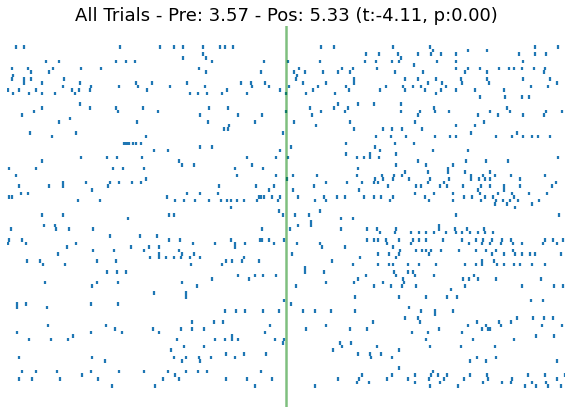

In [19]:
# Plot raster across all chest opening events
plot_rasters(all_trials_chest, xlim=trial_range, vline=0, figsize=(10, 7), 
             title='All Trials - Pre: {:1.2f} - Pos: {:1.2f} (t:{:1.2f}, p:{:1.2f})'.format(
                 fr_pre, fr_post, t_val, p_val))

## Chest Opening - Split by Stimulus Content

In [20]:
# Create masks to sub-select full & empty chests
full_mask = nwbfile.trials.full_chest.data[:]
empty_mask = np.invert(full_mask)

In [21]:
# Calculate how many full/empty chests there are
n_empty = sum(empty_mask)
n_full = sum(full_mask)

In [22]:
# Check how many full/empty chests there are
print('Number of empty chests: \t{}'.format(n_empty))
print('Number of full chests: \t\t{}'.format(n_full))

Number of empty chests: 	36
Number of full chests: 		60


In [23]:
# Sub-select full & empty chest trials
empty_trials = select_from_list(all_trials_chest, empty_mask)
full_trials = select_from_list(all_trials_chest, full_mask)

In [24]:
# Calculate firing rate pre & post chest opening
fr_pre_e, fr_post_e = calc_trial_frs(empty_trials)
fr_pre_f, fr_post_f = calc_trial_frs(full_trials)

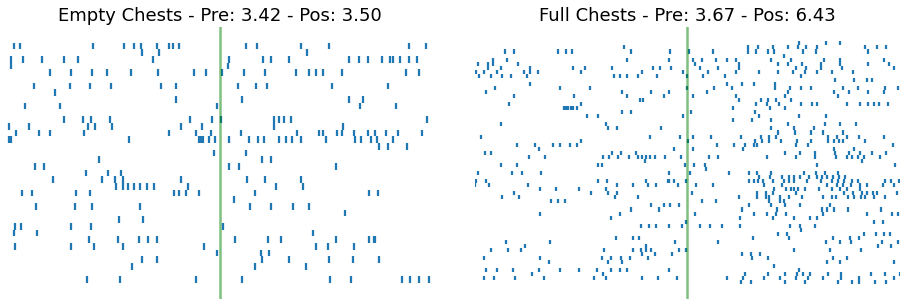

In [25]:
# Plot a comparison of full and empty trials
_, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_rasters(empty_trials, xlim=trial_range, vline=0, ax=axes[0], 
             title='Empty Chests - Pre: {:1.2f} - Pos: {:1.2f}'.format(fr_pre_e, fr_post_e))
plot_rasters(full_trials, xlim=trial_range, vline=0, ax=axes[1],
             title='Full Chests - Pre: {:1.2f} - Pos: {:1.2f}'.format(fr_pre_f, fr_post_f))
plt.subplots_adjust(wspace=0.1)

## Recall Events

In [26]:
# Get the response times of interest
prompts = nwbfile.trials.confidence_prompt_time[:]
responses = nwbfile.trials.response_time[:]

In [27]:
# Check the number of recall events
assert len(prompts) == len(responses)
n_recalls = len(prompts)
print('Number of recall events: {}'.format(n_recalls))

Number of recall events: 60


### Response Prompt

In [28]:
# Gather neural data around trials of interest
all_trials_prompt = []
for prompt in prompts:
    time_range = restrict_range(spikes, prompt + trial_range[0], prompt + trial_range[1])
    all_trials_prompt.append(time_range - prompt)

In [29]:
# Compute statistical test
t_val, p_val = ttest_rel(*calc_trial_frs(all_trials_prompt, average=False))

In [30]:
# Calculate firing rate pre & post chest opening
fr_pre, fr_post = calc_trial_frs(all_trials_prompt)

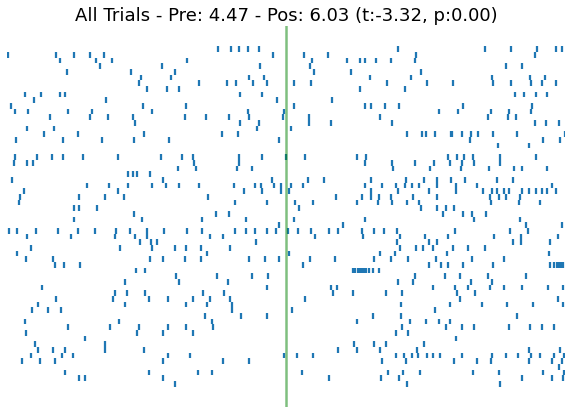

In [31]:
# Plot raster across all response prompts
plot_rasters(all_trials_prompt, xlim=trial_range, vline=0, figsize=(10, 7), 
             title='All Trials - Pre: {:1.2f} - Pos: {:1.2f} (t:{:1.2f}, p:{:1.2f})'.format(
                 fr_pre, fr_post, t_val, p_val))

### Response Button Press

In [32]:
# Gather neural data around trials of interest
all_trials_response = []
for response in responses:
    time_range = restrict_range(spikes, response + trial_range[0], response + trial_range[1])
    all_trials_response.append(time_range - response)

In [33]:
# Compute statistical test
t_val, p_val = ttest_rel(*calc_trial_frs(all_trials_response, average=False))

In [34]:
# Calculate firing rate pre & post chest opening
fr_pre, fr_post = calc_trial_frs(all_trials_response)

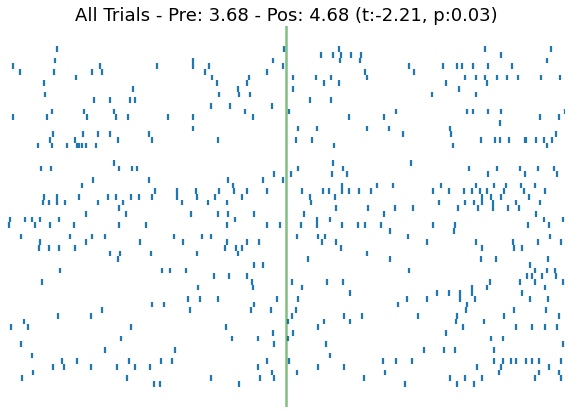

In [35]:
# Plot raster across all response button presses
plot_rasters(all_trials_response, xlim=trial_range, vline=0, figsize=(10, 7), 
             title='All Trials - Pre: {:1.2f} - Pos: {:1.2f} (t:{:1.2f}, p:{:1.2f})'.format(
                 fr_pre, fr_post, t_val, p_val))

### Check All Cells

In [36]:
# Set which set of events to run
event_label = 'responses' # 'openings', 'prompts', 'responses'

In [37]:
# # Run across all cells
# events = {'openings' : openings, 'prompts' : prompts, 'responses' : responses}[event_label]
# for uind in keep_inds:

#     spikes = nwbfile.units.get_unit_spike_times(uind)
    
#     all_trials = []
#     for event in events:
#         time_range = restrict_range(spikes, event + trial_range[0], event + trial_range[1])
#         all_trials.append(time_range - event)    
    
#     # Plot all trials together
#     plot_rasters(all_trials, xlim=trial_range, vline=0,
#                  title='Neuron #{} - Pre: {:1.2f} - Pos: {:1.2f}'.format(uind, *calc_trial_frs(all_trials)),
#                  figsize=(10, 7))

#     # Plot separate rasters for full and empty trials
#     if event_label == 'openings':
#         _, axes = plt.subplots(1, 2, figsize=(16, 5))
#         empty_trials = select_from_list(all_trials, empty_mask)
#         plot_rasters(empty_trials, xlim=trial_range, vline=0,
#                      title='Empty Chests - Pre: {:1.2f} - Pos: {:1.2f}'.format(*calc_trial_frs(empty_trials)),
#                      ax=axes[0])
#         full_trials = select_from_list(all_trials, full_mask)
#         plot_rasters(full_trials, xlim=trial_range, vline=0,
#                      title='Full Chests - Pre: {:1.2f} - Pos: {:1.2f}'.format(*calc_trial_frs(full_trials)),
#                      ax=axes[1])
#         plt.subplots_adjust(wspace=0.1)
#         plt.suptitle('Neuron #{}'.format(uind))